# Serial simulation

In [1]:
import logging
import sys

root = logging.getLogger()
root.setLevel(logging.DEBUG)

In [2]:
import numpy as np
from decimal import Decimal

In [3]:
from latticemc.definitions import Lattice, LatticeState, OrderParametersHistory, DefiningParameters
from latticemc.lattice_tools import initialize_partially_ordered
from latticemc.random_quaternion import random_quaternion
from latticemc.updaters import Updater, OrderParametersCalculator, FluctuationsCalculator, DerivativeWiggleRateAdjustor, RandomWiggleRateAdjustor, CallbackUpdater
from latticemc.failsafe import failsafe_save_simulation
from latticemc.parallel import SimulationRunner
from latticemc import simulation_numba

In [4]:
lattice = Lattice(9, 9, 9)
initialize_partially_ordered(lattice, x=random_quaternion(1))

model_params = DefiningParameters(temperature=Decimal(0.9), lam=Decimal(0.3), tau=Decimal(1))
state = LatticeState(parameters=model_params, lattice=lattice)
order_parameters_history = {model_params: OrderParametersHistory()}

In [8]:
%matplotlib widget
from matplotlib import pyplot as plt
from IPython import display

def plot_progress(state: LatticeState, max_window: float, step: int):
    op = order_parameters_history[state.parameters].order_parameters
    plt.close()
    fig,ax = plt.subplots(3);
    fig.tight_layout();
    fig.set_size_inches(10,10);
    start = step if op.size < max_window else (op.size-max_window)
    size = op.size if op.size < max_window else max_window
    x = np.linspace(start, start+size, size//step-1)
    ax[0].plot(x, op['energy'][start::step], label='energy');
    ax[1].plot(x, op['p'][start::step], label='p');
    ax[1].plot(x, op['q0'][start::step], label='q0');
    ax[1].plot(x, op['q2'][start::step], label='q2');
    ax[1].plot(x, op['d322'][start::step], label='d322');
    ax[2].plot(x, op['w'][start::step], label='w');
    ax[0].legend();
    ax[1].legend();
    ax[2].legend();
    display.display(fig)
    display.clear_output(wait=True)

In [9]:
order_parameters_calculator = OrderParametersCalculator(order_parameters_history[model_params], how_often=1, since_when=1)#, printEvery=50)
fluctuations_calculator = FluctuationsCalculator(order_parameters_history[model_params], window=100, how_often=50, since_when=100)#, printEvery=50)
updaters = [
    order_parameters_calculator,
    fluctuations_calculator,
    CallbackUpdater(lambda state: plot_progress(state, step=10, max_window=10000), how_often=100, since_when=10),
    DerivativeWiggleRateAdjustor(order_parameters_history=order_parameters_history[model_params], how_many=100, how_often=10, since_when=101),
    RandomWiggleRateAdjustor(scale=0.001, how_often=10, since_when=1),
    RandomWiggleRateAdjustor(scale=1.0, reset_value=1.0, how_often=1000, since_when=1000),
]

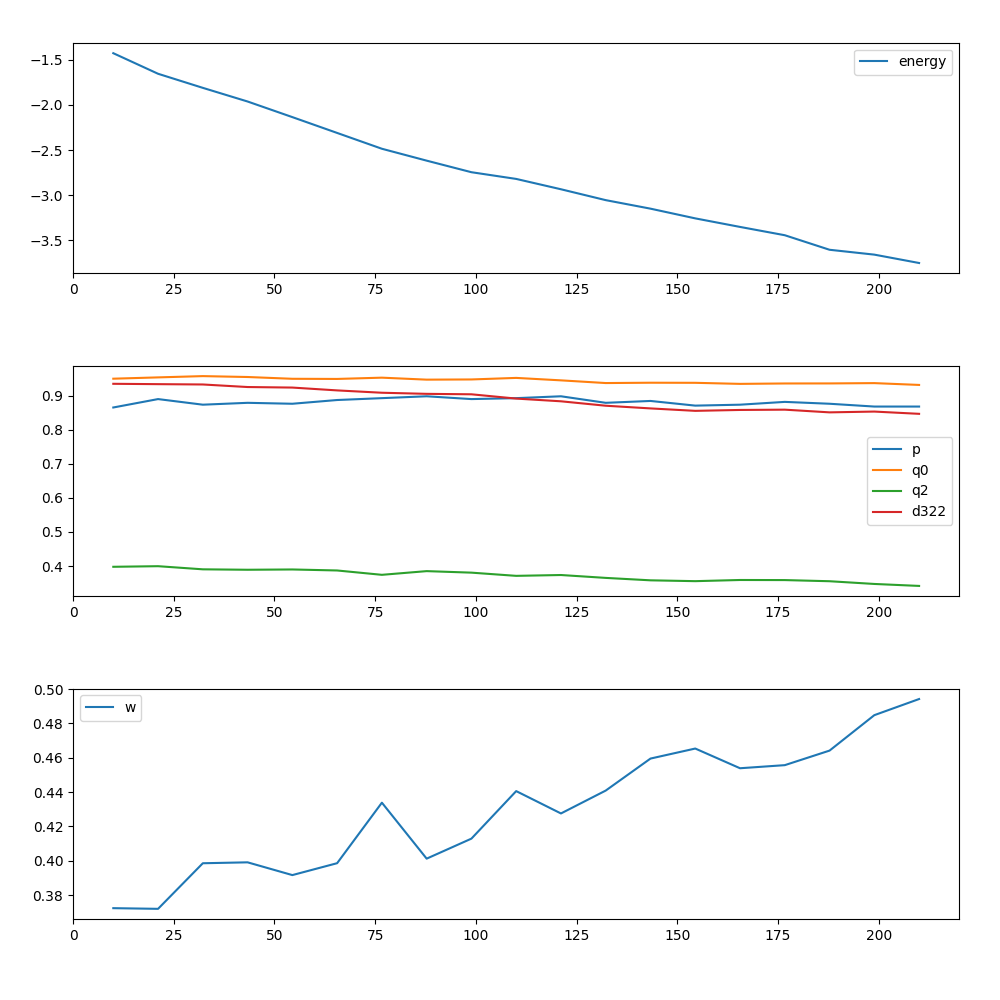

In [10]:
for it in range(100):
    simulation_numba.do_lattice_state_update(state)

    for u in updaters:
        u.perform(state)

# Parallel simulations

**WARNING**: The simulation will create as many subprocesses as there are temperatures. This will use a lot of memory. Expect crashes!

These settings should run fine on an 8-core processor with 16GB of RAM.

In [25]:
temperatures = np.arange(0.4, 1.7, 0.1)
states = [LatticeState(parameters=DefiningParameters(temperature=round(Decimal(t), 2), lam=Decimal(0.3), tau=1),
                       lattice=Lattice(11, 11, 11))
          for t in temperatures]
for state in states:
    initialize_partially_ordered(state.lattice, x=random_quaternion(1.0))

order_parameters_history = {state.parameters: OrderParametersHistory() for state in states}

In [26]:
per_state_updaters = [
    #DerivativeWiggleRateAdjustor(howMany=100, how_often=10, since_when=100),
    RandomWiggleRateAdjustor(scale=0.001, how_often=10, since_when=10),
    RandomWiggleRateAdjustor(scale=1.0, reset_value=1.0, how_often=1000, since_when=1000)
]

runner = SimulationRunner(states,
                          order_parameters_history,
                          cycles=1000000,
                          report_order_parameters_every=10,
                          report_state_every=1000,
                          per_state_updaters=per_state_updaters,
                          parallel_tempering_interval=10)
runner.start()

In [27]:
temperatures

array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6])

C:\Users\troja\AppData\Local\Temp\ipykernel_14532\2419468638.py:31: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  self.ani = FuncAnimation(self.opfig, self.plot_update, interval=1000, repeat=True)


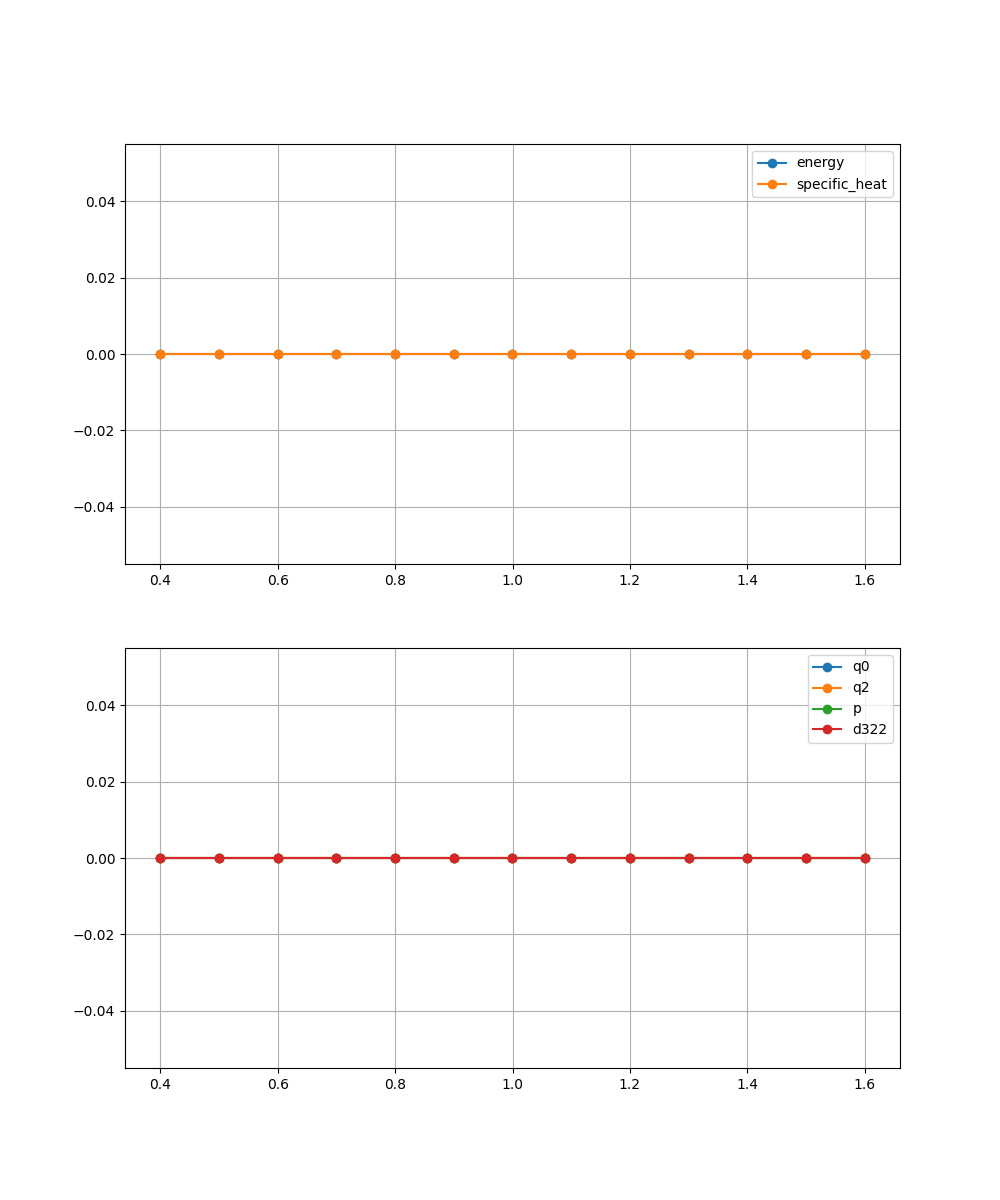

In [44]:
%matplotlib widget
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

class Plotter:
    def __init__(self, temperatures, order_parameters_history, window=1000):
        self.order_parameters_history = order_parameters_history
        self.x = [float(t) for t in temperatures]
        self.energy = [0 for _ in self.x]
        self.specific_heat = [0 for _ in self.x]
        self.q0 = [0 for _ in self.x]
        self.q2 = [0 for _ in self.x]
        self.par = [0 for _ in self.x]
        self.d322 = [0 for _ in self.x]
        self.w = [0 for _ in self.x]
        self.window = window

        self.opfig, self.opax = plt.subplots(2);
        self.opfig.set_size_inches(10,12)
        self.opax[0].plot(self.x,self.energy, label='energy', marker='o', linestyle=None);
        self.opax[0].plot(self.x,self.specific_heat, label='specific_heat', marker='o', linestyle=None);
        self.opax[1].plot(self.x,self.q0, label='q0', marker='o', linestyle=None);
        self.opax[1].plot(self.x,self.q2, label='q2', marker='o', linestyle=None);
        self.opax[1].plot(self.x,self.par, label='p', marker='o', linestyle=None);
        self.opax[1].plot(self.x,self.d322, label='d322', marker='o', linestyle=None);
        self.opax[0].legend();
        self.opax[1].legend();
        self.opax[0].grid();
        self.opax[1].grid();
        
        self.ani = FuncAnimation(self.opfig, self.plot_update, interval=1000, repeat=True)
        self.opfig

    def plot_update(self, _):
        for p, oph in self.order_parameters_history.items():
            op = oph.order_parameters
            fl = oph.fluctuations
            t_index = np.nonzero(np.isclose(self.x, float(p.temperature)))[0][0]
            size = op.size if op.size < self.window else self.window
            fl_size = fl.size if fl.size < self.window else self.window
            
            self.energy[t_index] = op['energy'][-size:].mean() if op.size else 0
            self.specific_heat[t_index] = fl['energy'][-fl_size:].mean() if fl.size else 0
            self.q0[t_index] = op['q0'][-size:].mean() if op.size else 0
            self.q2[t_index] = op['q2'][-size:].mean() if op.size else 0
            self.par[t_index] = np.abs(op['p'][-size:]).mean() if op.size else 0
            self.d322[t_index] = op['d322'][-size:].mean() if op.size else 0

        self.opax[0].lines[0].set_ydata(self.energy)
        self.opax[0].lines[1].set_ydata(self.specific_heat)
        self.opax[1].lines[0].set_ydata(self.q0)
        self.opax[1].lines[1].set_ydata(self.q2)
        self.opax[1].lines[2].set_ydata(self.par)
        self.opax[1].lines[3].set_ydata(self.d322)

        self.opax[0].relim()
        self.opax[0].autoscale_view()
        self.opax[1].relim()
        self.opax[1].autoscale_view()

plotter = Plotter(temperatures, order_parameters_history, window=10000)

D:\Devel\latticemc\.venv311\Lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


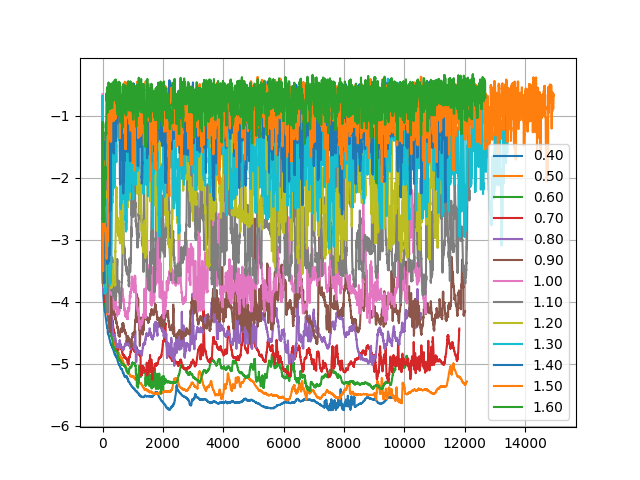

In [43]:
fig, ax = plt.subplots();
for state in states:
    ax.plot(order_parameters_history[state.parameters].order_parameters['energy'], label=state.parameters.temperature)
ax.legend()
ax.grid()

In [24]:
## uncomment to stop the simulation
# runner.stop()